In [1]:


import numpy as np
from tqdm import tqdm
import random
import gym
from gym.wrappers import RecordVideo
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML

In [3]:
#Setting up the environment
env=gym.make("Taxi-v3",render_mode='ansi')

env.reset()
#Current State
#state is in the form of [taxi_row,taxi_col,passenger_location,destination]
# passenger locations        # Destinations
# 0: R(ed)                   # 0: R(ed) 
# 1: G(reen)                 # 1: G(reen)
# 2: Y(ellow)                # 2: Y(ellow)
# 3: B(lue)                  # 3: B(lue)
# 4: in taxi

# 0,0 is top left

print(env.s)
print("decoded state= ",list(env.decode(env.s)))

action = ["south", "north", "east", "west",'pickup','drop']
#correspond to [0,1,2,3,4,5] that's actually passed to the environment

print ("Number of actions that an agent can take:", env.action_space)

# Example Transitions
rnd_action = random.randint(0, 5)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal,truncated, t_prob, = env.step(rnd_action)

print ("Transition probability:", t_prob) # action_mask tell us which actions will result in a change of state
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)
env.render()

402
decoded state=  [4, 0, 0, 2]
Number of actions that an agent can take: Discrete(6)
Action taken: drop
Transition probability: {'prob': 1.0, 'action_mask': array([0, 1, 0, 0, 0, 0], dtype=int8)}
Next state: 402
Reward recieved: -10
Terminal state: False


'+---------+\n|\x1bR\x1b: | : :G|\n| : | : : |\n| : : : : |\n| | : | : |\n|\x1b\x1bY\x1b\x1b| : |B: |\n+---------+\n  (Dropoff)\n'

In [4]:
# define options here

def egreedy_policy(Q,state,eps):
    if np.random.rand() < eps:
        action = np.random.randint(0,10)  # Explore action space
    else:
        action = np.argmax(Q[state])  # Exploit learned values
    return action
def egreedy__option_policy(Q,state,eps):
    if np.random.rand() < eps:
        action = np.random.randint(0,4)  # Explore action space
    else:
        action = np.argmax(Q[state])  # Exploit learned values
    return action

In [5]:
# define e-greedy policy
q_values_SMDP = np.zeros((500,10))
R_option_policy=np.zeros((25,4)) # action 6
G_option_policy=np.zeros((25,4)) # action 7 
B_option_policy=np.zeros((25,4)) # action 8 
Y_option_policy=np.zeros((25,4)) # action 9
#### SMDP Q-Learning 

# Add parameters you might need here
gamma = 0.9
alpha=0.8
epsilon=0.2
eps1=0.2
eps2=0.2
eps3=0.2
eps4=0.2
decay=0.99
eps_min=0.01
episode_rewards = []
# Iterate over 1000 episodes
for _ in tqdm(range(1000)):
    state,_ = env.reset()   
    total_reward = 0

    done = False
    step_count=0

    # While episode is not over
    while not done :
        step_count+=1
        
        # Choose action        
        action = egreedy_policy(q_values_SMDP, state,epsilon)
        epsilon=max(eps_min,epsilon*decay)

        # Checking if primitive action
        if action < 6:
            # Perform regular Q-Learning update for state-action pair
            next_state, reward,done,_,_ = env.step(action)
            q_values_SMDP[state][action] += alpha * (reward + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state][action])
            total_reward += reward
            state=next_state
        # Checking if action chosen is an option
        reward_bar = 0
        s_state=state
        if action == 6: # action => red
            k=0
            state_row,state_col,_,_=list(env.decode(state))
            pos=[state_row,state_col]
            red_pos=[0,0]
            while pos !=  red_pos :
    
                k+=1
                state_no=state_row*5+state_col
                action=egreedy__option_policy(R_option_policy,state_no,eps1)
                eps1=max(eps_min,eps1*decay)
                next_state, reward,done,_,_ = env.step(action)
                state_row,state_col,_,_=list(env.decode(next_state))
                next_state_no=state_row*5+state_col

                R_option_policy[state_no][action] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][action])
                # Is this formulation right? What is this term?
                reward_bar = gamma*reward_bar + reward
                
                state = next_state
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
            q_values_SMDP[s_state][6] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][6])
            total_reward += reward_bar
        if action == 7: # action => Green
            k=0
            state_row,state_col,_,_=list(env.decode(state))
            pos=[state_row,state_col]
            green_pos=[0,4]
         
            while pos !=  green_pos :
             
                k+=1
                state_no=state_row*5+state_col
                action=egreedy__option_policy(G_option_policy,state_no,eps2)
                eps2=max(eps_min,eps2*decay)
                next_state, reward,done,_,_ = env.step(action)
                state_row,state_col,_,_=list(env.decode(next_state))
                next_state_no=state_row*5+state_col

                G_option_policy[state_no][action] += alpha * (reward + gamma * np.max(G_option_policy[next_state_no]) - G_option_policy[state_no][action])
            
                reward_bar = gamma*reward_bar + reward
                
                state = next_state
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
            q_values_SMDP[s_state][7] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][7])
            total_reward += reward_bar

        if action == 8: # action => Blue
            k=0
            state_row,state_col,_,_=list(env.decode(state))
            pos=[state_row,state_col]
            blue_pos=[4,3]
    
            while pos !=  blue_pos :
           
                k+=1
                state_no=state_row*5+state_col
                action=egreedy__option_policy(B_option_policy,state_no,eps3)
                eps3=max(eps_min,eps3*decay)
                next_state, reward,done,_,_ = env.step(action)
                state_row,state_col,_,_=list(env.decode(next_state))
                next_state_no=state_row*5+state_col

                B_option_policy[state_no][action] += alpha * (reward + gamma * np.max(B_option_policy[next_state_no]) - B_option_policy[state_no][action])
              
                reward_bar = gamma*reward_bar + reward
                
                state = next_state
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
            q_values_SMDP[s_state][8] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][8])
            total_reward += reward_bar
        
        if action == 9: # action => Yellow
            k=0
            state_row,state_col,_,_=list(env.decode(state))
            pos=[state_row,state_col]
            yellow_pos=[4,0]

            while pos !=  yellow_pos :
    
                k+=1
                state_no=state_row*5+state_col
                action=egreedy__option_policy(Y_option_policy,state_no,eps4)
                eps4=max(eps_min,eps4*decay)
                next_state, reward,done,_,_ = env.step(action)
                state_row,state_col,_,_=list(env.decode(next_state))
                next_state_no=state_row*5+state_col

                Y_option_policy[state_no][action] += alpha * (reward + gamma * np.max(Y_option_policy[next_state_no]) - Y_option_policy[state_no][action])

                reward_bar = gamma*reward_bar + reward
                
                state = next_state
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
            q_values_SMDP[s_state][9] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][9])
            total_reward += reward_bar
    episode_rewards.append(total_reward)
    


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:27<00:00, 35.98it/s]


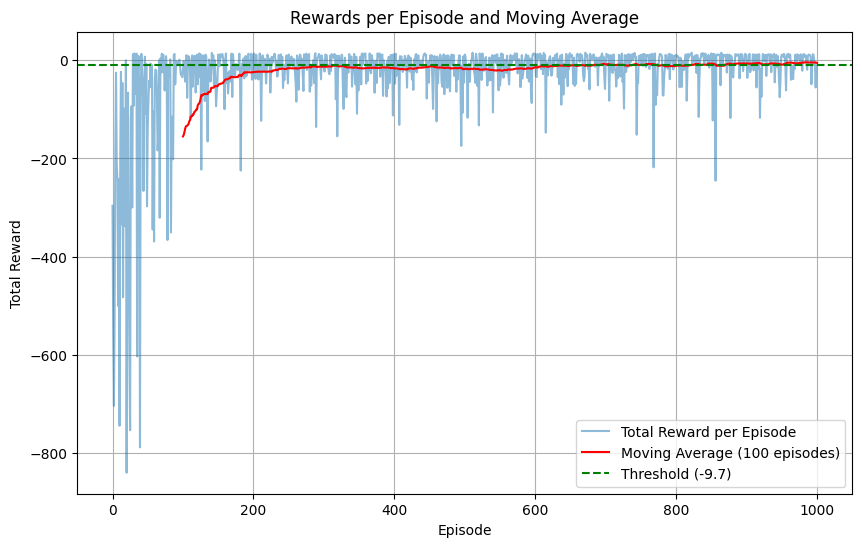

In [6]:
# Calculate the moving average of the last 100 episodes
moving_avg = np.convolve(episode_rewards, np.ones(100)/100, mode='valid')

# Visualize the rewards per episode and the moving average
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards, label='Total Reward per Episode', alpha=0.5)
plt.plot(range(100, len(episode_rewards)+1), moving_avg, color='red', label='Moving Average (100 episodes)')
plt.axhline(y=-9.7, color='green', linestyle='--', label='Threshold (-9.7)')
plt.title('Rewards per Episode and Moving Average')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

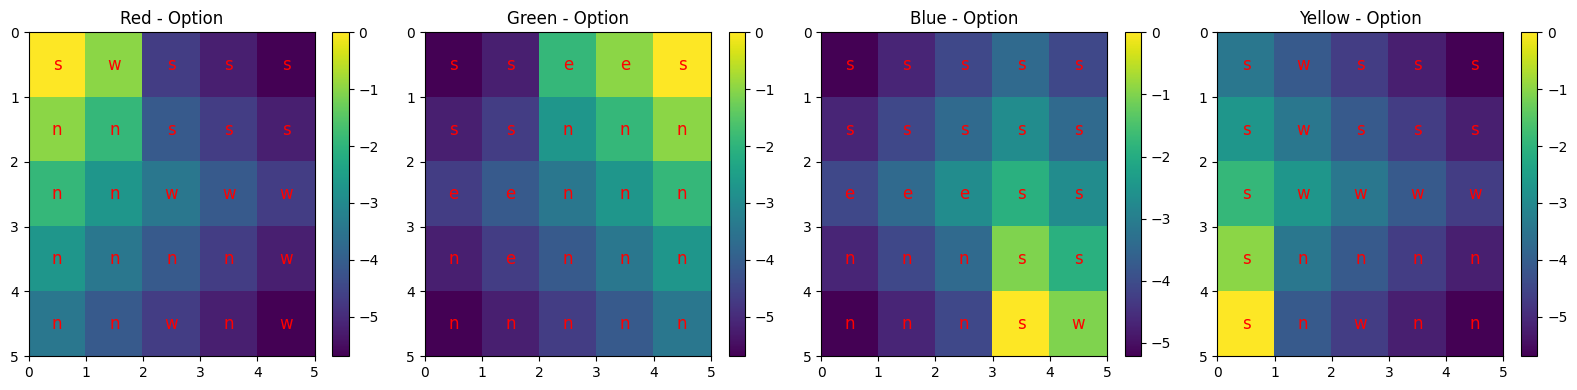

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_Q(Q_values, color_names, message="Q plot"):
    actions = ["south", "north", "east", "west"]

    fig, axes = plt.subplots(1, len(Q_values), figsize=(16, 4)) 

    for ax, q_value, color_name in zip(axes, Q_values, color_names):
        q_plot = np.zeros((5, 5, 4))
        for i in range(5):
            for j in range(5):
                state_num = i * 5 + j
                q_plot[i, j] = q_value[state_num]

        ax.set_title(f"{color_name} - {message}") 
        ax.pcolor(q_plot.max(-1), edgecolors='k', linewidths=2)
        plt.colorbar(ax.pcolor(q_plot.max(-1)), ax=ax)
        for i in range(5):
            for j in range(5):
                state_num = i * 5 + j
                if message == "Update Frequency":
                    anno = f'{np.sum(q_plot[i, j])}'
                    size = 'small'
                else:
                    anno = actions[np.argmax(q_plot[i, j])][0]
                    size = 'large'
                ax.text(j + 0.5, i + 0.5, anno, ha='center', va='center', color='red', size=size)
        ax.invert_yaxis()

    plt.tight_layout()
    plt.show()

# Example usage
plot_Q([R_option_policy, G_option_policy, B_option_policy, Y_option_policy], ["Red", "Green", "Blue", "Yellow"], "Option")


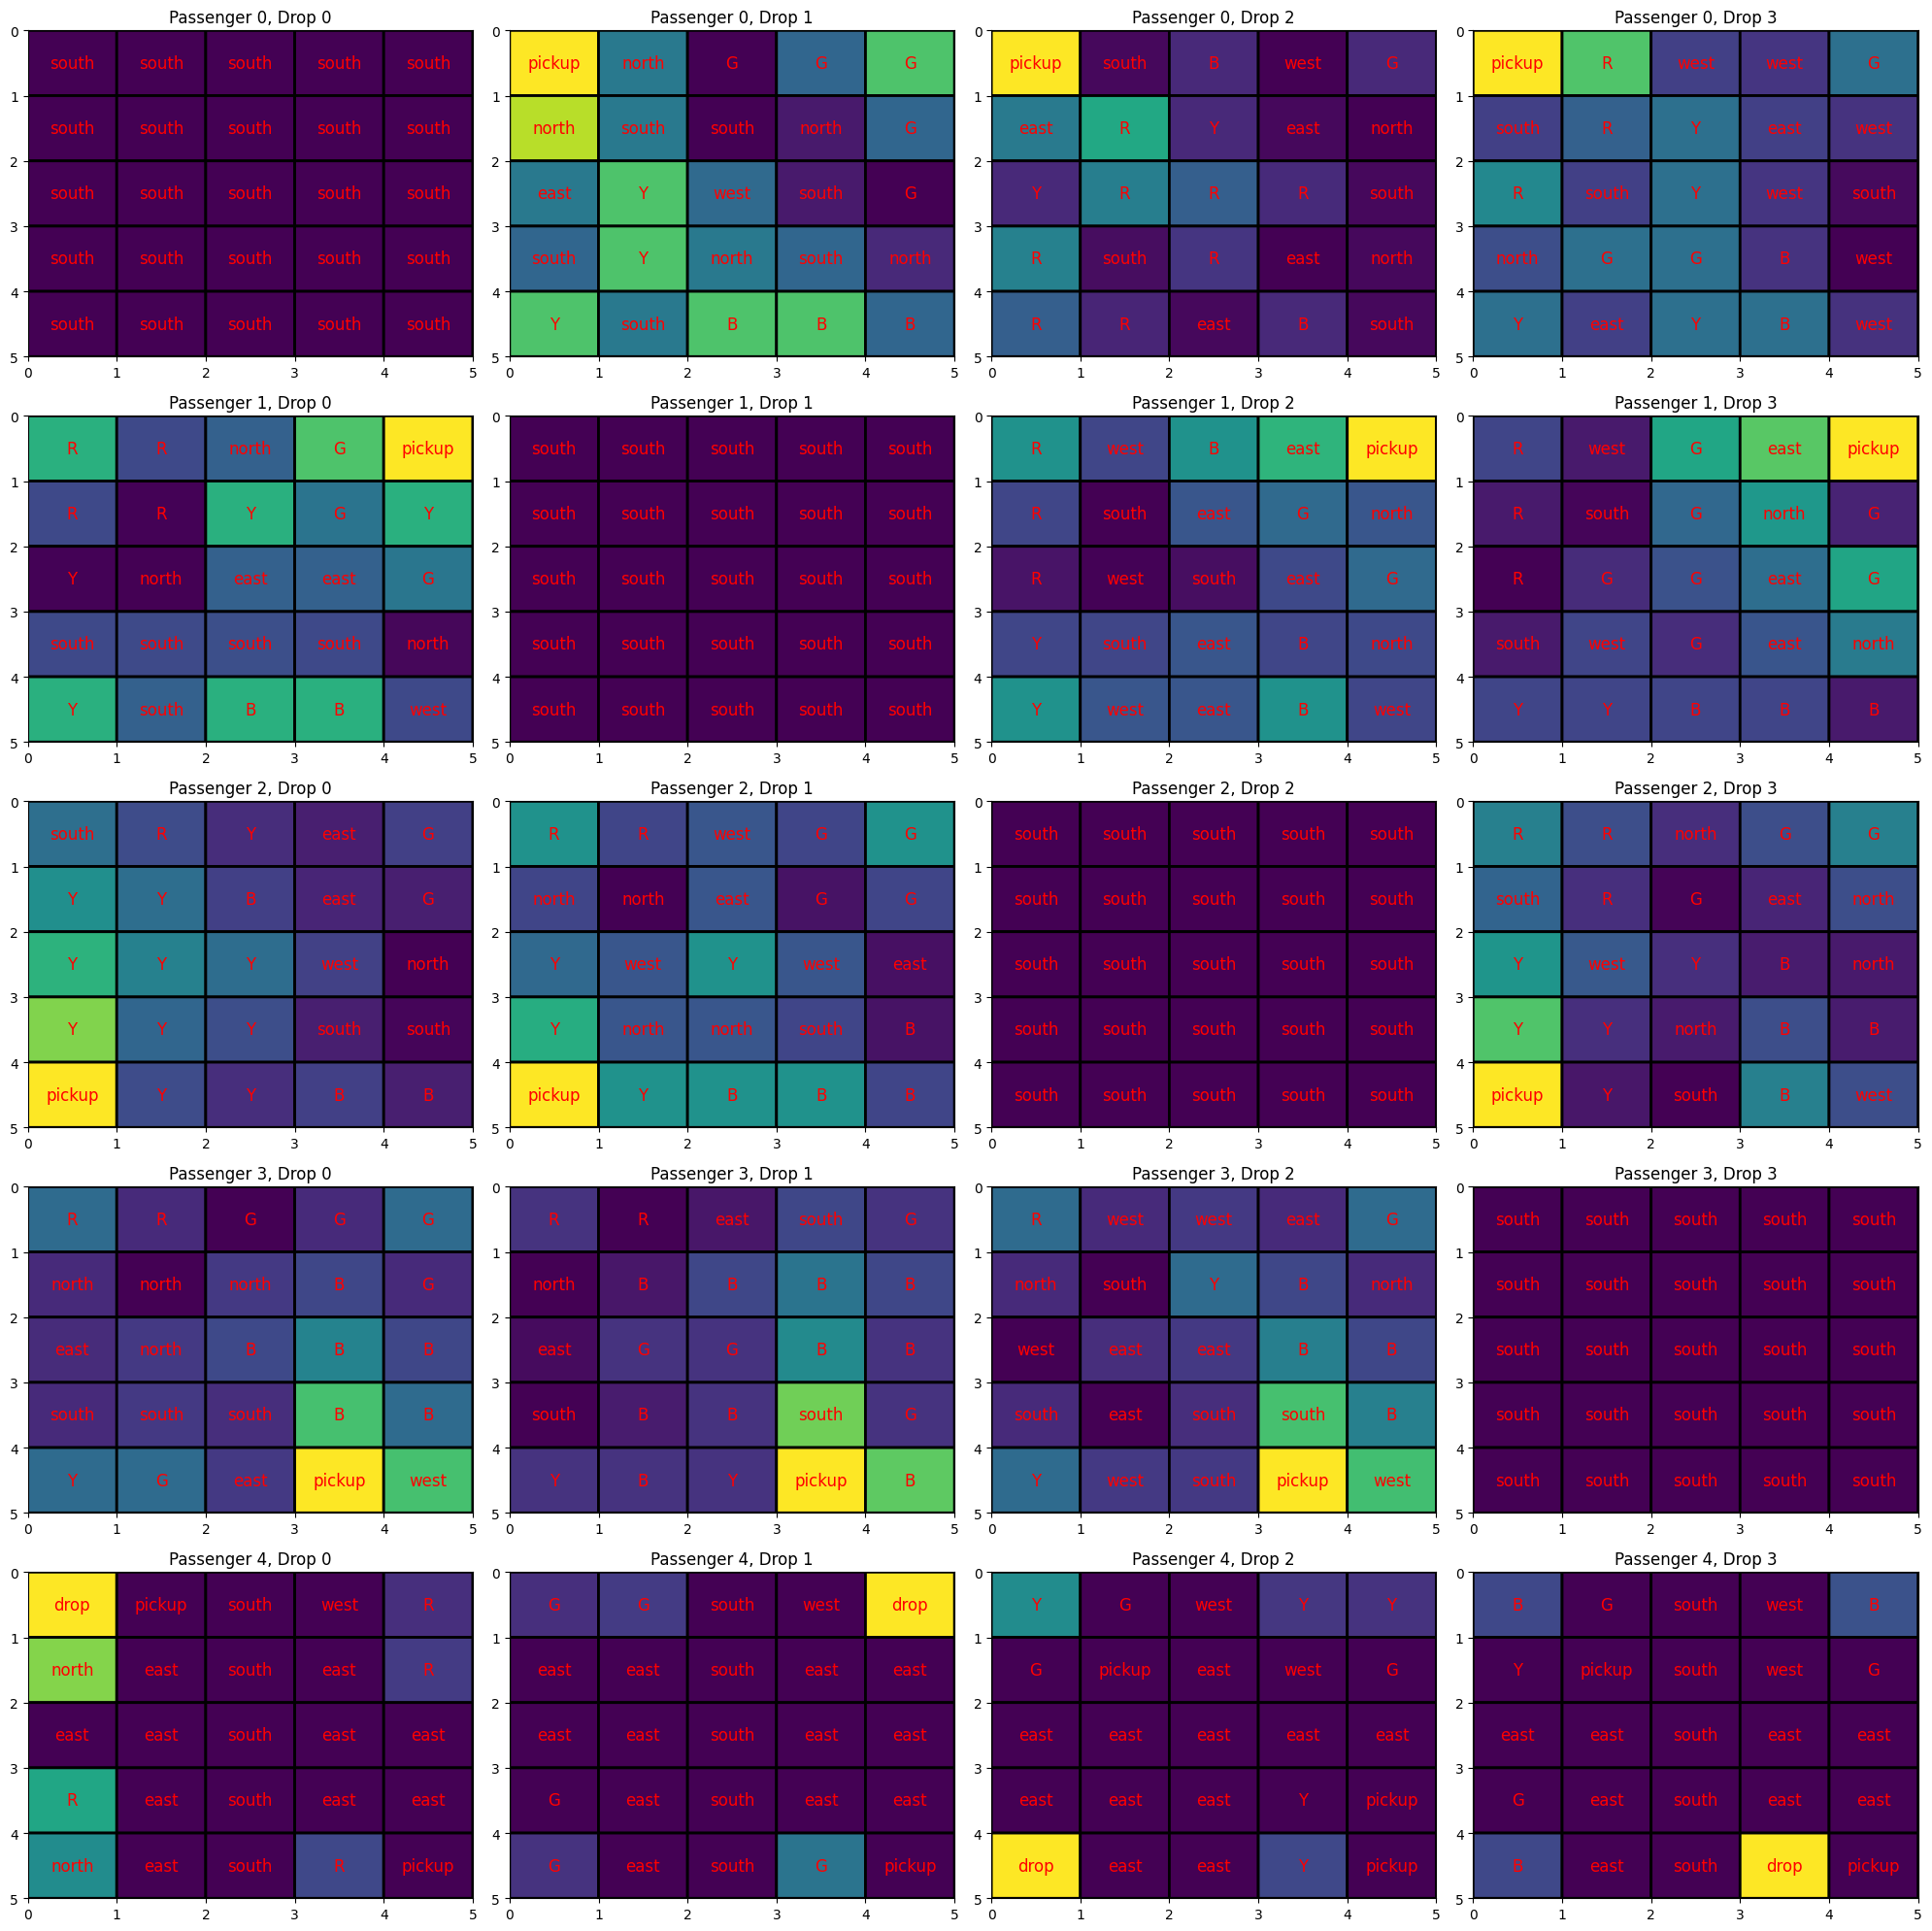

In [8]:

def visualize_SMDP_Q(q_values):
    actions = ["south", "north", "east", "west", 'pickup', 'drop', 'R', 'G', 'B', "Y"]
    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))

    for p in range(5):
        for d in range(4):
            Q = np.zeros((5, 5, 10))
            for r in range(5):
                for c in range(5):
                    state_num = 100 * r + 20 * c + 4 * p + d
                    Q[r, c] = q_values[state_num]

            ax = axes[p, d]
            ax.set_title(f"Passenger {p}, Drop {d}")
            ax.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
            for r in range(5):
                for c in range(5):
                    state_num = 100 * r + 20 * c + 4 * p + d
                    anno = actions[np.argmax(Q[r, c])]
                    ax.text(c + 0.5, r + 0.5, anno, ha='center', va='center', color='red', size='large')
            ax.invert_yaxis()

    plt.tight_layout()
    plt.show()


visualize_SMDP_Q(q_values_SMDP)


## Intra-option Q-Learning (still working on this)

In [14]:
# define e-greedy policy
q_values_Intra = np.zeros((500,10))
q_red = np.zeros((25,4))
q_green = np.zeros((25,4))
q_yellow = np.zeros((25,4))
q_blue = np.zeros((25,4))
option_q_values = [q_red, q_green, q_yellow, q_blue]

# Add parameters you might need here
gamma = 0.9
alpha=0.8
epsilon=0.1
decay=0.99
eps_min=0.01
episode_rewards = []
goal_pos=[[0,0],[0,4],[4,3],[4,0]]

# Iterate over 1000 episodes
for _ in tqdm(range(1000)):
    state,_ = env.reset()   
    total_reward = 0

    done = False
    step_count=0

    # While episode is not over
    while not done :
        step_count+=1

        # Choose action        
        action = egreedy_policy(q_values_Intra, state,epsilon)
        epsilon=max(eps_min,epsilon*decay)

        # Checking if primitive action
        if action < 4:
            # Perform regular Q-Learning update for state-action pair
            next_state, reward,done,_,_ = env.step(action)
            q_values_Intra[state][action] += alpha * (reward + gamma * np.max(q_values_Intra[next_state]) - q_values_Intra[state][action])
            state_row,state_col,_,_=list(env.decode(state))
            pos=[state_row,state_col]
            grid_state = state_row*5 + state_col
            next_state_row,next_state_col,_,_=list(env.decode(next_state))
            grid_next_state = next_state_row*5 + next_state_col

            for i in range(len(option_q_values)):
                if np.argmax(option_q_values[i]) == action:
                    option_q_values[i][grid_state][action] += alpha * (reward + gamma * np.max(option_q_values[i][grid_next_state]) - option_q_values[i][grid_state][action])
            total_reward += reward
            state=next_state

        elif action < 6: #pickup or drop action - cannot share with options so only main q table is updated
            
            next_state, reward,done,_,_ = env.step(action)
            q_values_Intra[state][action] += alpha * (reward + gamma * np.max(q_values_Intra[next_state]) - q_values_Intra[state][action])
            state_row,state_col,_,_=list(env.decode(state))
            pos=[state_row,state_col]
            next_state_row,next_state_col,_,_=list(env.decode(next_state))
            grid_next_state = next_state_row*5 + next_state_col

            total_reward += reward
            state=next_state

        # Checking if action chosen is an option
        else: # options chosen
            state_row,state_col,_,_=list(env.decode(state))
            grid_state = state_row * 5 + state_col
            option_no = action - 6

            optact = np.argmax(option_q_values[option_no][grid_state])   #check if this should be greedy or not
            next_state, reward,done,_,_ = env.step(optact)
            
            #update the q value for the option
            q_values_Intra[state][action] += alpha * (reward + gamma * np.max(q_values_Intra[next_state]) - q_values_Intra[state][action])
            #update the q value for the primitive action taken by the option
            q_values_Intra[state][optact] += alpha * (reward + gamma * np.max(q_values_Intra[next_state]) - q_values_Intra[state][optact])
            #update the q value for the primitive action taken by the option in the option q table
            option_q_values[option_no][grid_state][optact] += alpha * (reward + gamma * np.max(option_q_values[0][grid_next_state]) - option_q_values[0][grid_state][optact])
            total_reward += reward
            state=next_state

    episode_rewards.append(total_reward)
    



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:04<00:00, 230.60it/s]


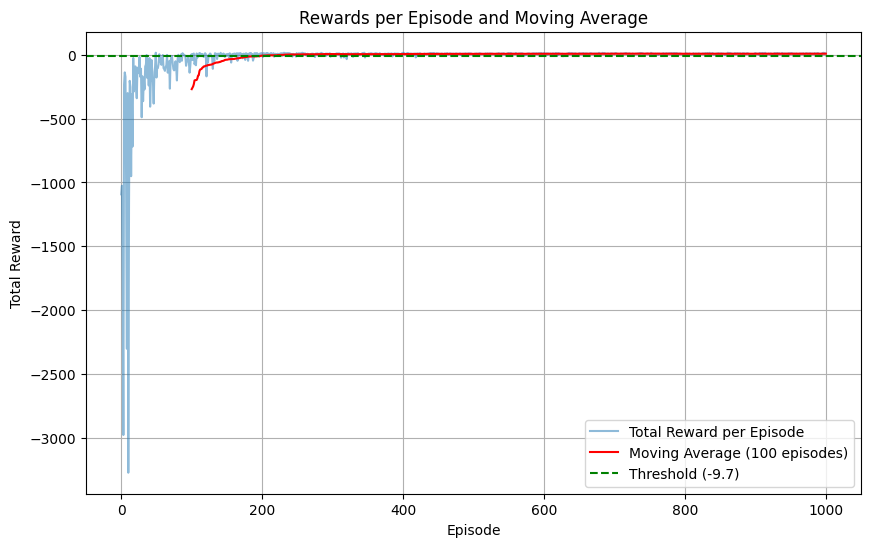

In [15]:
# Calculate the moving average of the last 100 episodes
moving_avg = np.convolve(episode_rewards, np.ones(100)/100, mode='valid')

# Visualize the rewards per episode and the moving average
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards, label='Total Reward per Episode', alpha=0.5)
plt.plot(range(100, len(episode_rewards)+1), moving_avg, color='red', label='Moving Average (100 episodes)')
plt.axhline(y=-9.7, color='green', linestyle='--', label='Threshold (-9.7)')
plt.title('Rewards per Episode and Moving Average')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()